In [1]:
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten,Activation
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot

In [3]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, BatchNormalization, LeakyReLU,ELU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import backend
import matplotlib.pyplot as plt

import os
from PIL import Image
import numpy as np
folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\test'
image_size = (16, 16)
image_arrays = []
image_size = (16, 16)

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        img_path = os.path.join(folder_path, filename)
        
        img = Image.open(img_path)
        
        img = img.resize(image_size)
        
        img_array = np.array(img)
        
        
        if img_array.ndim == 2:
            img_array = img_array[..., np.newaxis]
        
        
        image_arrays.append(img_array)

load_data = np.array(image_arrays).astype('float32')
load_data /= 255.0

print("Data shape:", load_data.shape)

Data shape: (100, 16, 16, 1)


In [5]:
from sklearn.model_selection import train_test_split
trainX, testX = train_test_split(load_data, test_size=0.2, random_state=42)

In [6]:
def load_real_samples():
    x = trainX.astype('float32')
    return x

In [9]:
# def load_real_samples():
#     X = load_data
#     return X

dataset = load_real_samples()

def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

class ClipConstraint(Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)


In [11]:
def define_discriminator(in_shape=(16, 16, 1)):
    init = RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
    #model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))
    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, kernel_constraint=const))
    #model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))
    model.add(Flatten())
    model.add(Dense(1))
    opt = RMSprop(learning_rate=0.00005, decay=8e-8)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

d_model = define_discriminator()
d_model.summary()

C:\jupyter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\jupyter\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 8, 8, 64)            │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_1 (ELU)                          │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,337 (524.75 KB)

 Trainable params: 134,337 (524.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def define_generator():
    init = RandomNormal(stddev=0.03)
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=(16, 16, 1)))
    #model.add(BatchNormalization())
    model.add(ELU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(2048))
    model.add(ELU(alpha=1.0))
    model.add(Dense(1024))
    model.add(ELU(alpha=1.0))
    model.add(Dense(256))
    model.add(ELU(alpha=1.0))

    model.add(Reshape((16, 16, 1)))
    
    model.add(Conv2D(1, (3,3), activation='tanh', padding='same', kernel_initializer=init))
    
    return model

g_model =  define_generator()
g_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_2 (ELU)                          │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │      33,556,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_3 (ELU)                          │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_4 (ELU)                          │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_5 (ELU)                          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 1)           │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,917,706 (137.02 MB)

 Trainable params: 35,917,706 (137.02 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = RMSprop(learning_rate=0.00005, decay=8e-8)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 16, 16, 1)           │      35,917,706 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │         134,337 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,052,043 (137.53 MB)

 Trainable params: 35,917,706 (137.02 MB)

 Non-trainable params: 134,337 (524.75 KB)

In [17]:
import os
from PIL import Image
import numpy as np
folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\train'
image_size = (16, 16)
image_arrays = []
image_size = (16, 16)

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        img_path = os.path.join(folder_path, filename)
        
        img = Image.open(img_path)
        
        img = img.resize(image_size)
        
        img_array = np.array(img)
        
        
        if img_array.ndim == 2:
            img_array = img_array[..., np.newaxis]
        
        
        image_arrays.append(img_array)

modified_data = np.array(image_arrays).astype('float32')
modified_data /= 255.0

print("Data shape:", modified_data.shape)

Data shape: (80, 16, 16, 1)


In [19]:
modified_data

array([[[[ 2.5315110e-03],
         [-3.9176471e+00],
         [ 2.4171500e-03],
         ...,
         [-3.9176471e+00],
         [-3.9176471e+00],
         [ 2.0779206e-03]],

        [[-3.9176471e+00],
         [-3.9176471e+00],
         [ 2.3746814e-03],
         ...,
         [ 2.1351750e-03],
         [-3.9176471e+00],
         [ 2.1271431e-03]],

        [[ 2.5367048e-03],
         [-3.9176471e+00],
         [-3.9176471e+00],
         ...,
         [ 2.2930412e-03],
         [ 2.2348207e-03],
         [ 2.2328284e-03]],

        ...,

        [[-3.9176471e+00],
         [-3.9176471e+00],
         [-3.9176471e+00],
         ...,
         [ 2.2932517e-03],
         [ 2.3368851e-03],
         [ 2.3385608e-03]],

        [[-3.9176471e+00],
         [ 2.1863063e-03],
         [-3.9176471e+00],
         ...,
         [ 2.2712811e-03],
         [ 2.2699039e-03],
         [ 2.2684971e-03]],

        [[ 2.1968007e-03],
         [-3.9176471e+00],
         [-3.9176471e+00],
         ...,
 

In [21]:
def generate_fake_samples(g_model, modified_data, n_samples):
    if not isinstance(modified_data, np.ndarray):
        raise TypeError("modified_data should be a numpy array.")
    if n_samples > len(modified_data):
        raise ValueError("Batch size exceeds the number of available images.")
    indices = np.random.randint(0, len(modified_data), n_samples)
    input_images = modified_data[indices] 
    fake_images = g_model.predict(input_images)
    y = np.zeros((n_samples, 1))
    return fake_images, y

In [23]:
def train(g_model, d_model, gan_model, dataset, modified_data, n_epochs=20, n_batch=4, n_critic=5):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    half_batch = int(n_batch / 2)

    c1_hist, c2_hist, g_hist = [], [], []

    for i in range(n_steps):
        c1_tmp, c2_tmp = [], []
        for _ in range(n_critic):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            c_loss1 = d_model.train_on_batch(X_real, y_real)
           
            if isinstance(c_loss1, list):
                c_loss1 = c_loss1[0]
            c1_tmp.append(c_loss1)
            
            X_fake, y_fake = generate_fake_samples(g_model, modified_data, half_batch)
            c_loss2 = d_model.train_on_batch(X_fake, y_fake)
            
            if isinstance(c_loss2, list):
                c_loss2 = c_loss2[0]
            c2_tmp.append(c_loss2)
        
        c1_mean = np.mean(c1_tmp)
        c2_mean = np.mean(c2_tmp)
        
    
        c1_mean = float(c1_mean)
        c2_mean = float(c2_mean)
        
        c1_hist.append(c1_mean)
        c2_hist.append(c2_mean)
        
        X_gan, y_gan = generate_fake_samples(g_model, modified_data, n_batch)
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        if isinstance(g_loss, list):
            g_loss = g_loss[0]
        g_loss = float(g_loss)
        
        g_hist.append(g_loss)
        
        print(f'>{i+1}, c1={c1_mean:.3f}, c2={c2_mean:.3f}, g={g_loss:.3f}')
        
        
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, modified_data)
    plot_history(c1_hist, c2_hist, g_hist)

In [25]:
def summarize_performance(step, g_model, modified_data, n_samples=8):
    X, _ = generate_fake_samples(g_model, modified_data, n_samples)
    X = (X + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
    
    save_dir = r'C:\Users\OptiSAR\Desktop\gan\save image\image'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    
    for i in range(n_samples):
        plt.subplot(2, 4, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    filename1 = os.path.join(save_dir, f'plot_{step + 1:04d}.tif')  
    plt.savefig(filename1, format='tiff')  
    plt.close()

def plot_history(d1_hist, d2_hist, g_hist):
    save_dir = r'C:\Users\OptiSAR\Desktop\gan\save image\image'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.plot(d1_hist, label='discriminator_loss_real')
    plt.plot(d2_hist, label='discriminator_loss_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    filename2 = os.path.join(save_dir, 'line_plot_loss.png')
    plt.savefig(filename2)  
    plt.close()

In [ ]:
d_model = define_discriminator()
g_model = define_generator()
gan_model = define_gan(g_model, d_model)

train(g_model, d_model, gan_model, dataset, modified_data)

C:\jupyter\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
>1, c1=6.047, c2=4.457, g=4.440
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
>2, c1=4.738, c2=4.432, g=4.446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
>3, c1=4.614, c2=4.434, g=4.431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [33]:
import os
from PIL import Image
import os
from PIL import Image
import numpy as np

import os
from PIL import Image
import numpy as np
folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\only_test'
image_size = (16, 16)
image_arrays = []
image_size = (16, 16)

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        img_path = os.path.join(folder_path, filename)
        
        img = Image.open(img_path)
        
        img = img.resize(image_size)
        
        img_array = np.array(img)
        
        
        if img_array.ndim == 2:
            img_array = img_array[..., np.newaxis]
        
        
        image_arrays.append(img_array)

test_data = np.array(image_arrays).astype('float32')
test_data /= 255.0

print("Data shape:", test_data.shape)

Data shape: (47, 16, 16, 1)


In [35]:
x1= test_data[0:1]

In [37]:
x1[0,:,:,0]

array([[ 8.8861142e-04, -3.9176471e+00, -3.9176471e+00,  1.1161220e-03,
         1.1194251e-03,  1.1784229e-03,  1.1247280e-03, -3.9176471e+00,
         1.0842852e-03,  1.1397487e-03,  1.1449000e-03, -3.9176471e+00,
         9.8860357e-04, -3.9176471e+00,  1.0031927e-03,  1.0028314e-03],
       [-3.9176471e+00, -3.9176471e+00, -3.9176471e+00, -3.9176471e+00,
         1.1632234e-03,  1.1195547e-03,  1.0904872e-03, -3.9176471e+00,
         1.0657480e-03,  1.1333616e-03,  1.1530932e-03,  1.1322798e-03,
         1.0994686e-03,  1.0577003e-03,  1.0230705e-03,  9.9311362e-04],
       [ 1.0498163e-03,  1.0617750e-03,  1.0390293e-03, -3.9176471e+00,
         9.7394921e-04,  1.0172328e-03,  1.0919054e-03, -3.9176471e+00,
         1.1122719e-03,  1.1054499e-03,  1.1156364e-03,  1.1573493e-03,
         1.1493752e-03,  1.0868956e-03, -3.9176471e+00,  9.7797287e-04],
       [ 1.0431379e-03,  1.0109470e-03,  9.5226528e-04,  9.5144240e-04,
         9.7628165e-04,  1.0108771e-03,  1.0664618e-03,  1.13

In [39]:
im_out = g_model.predict(x1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


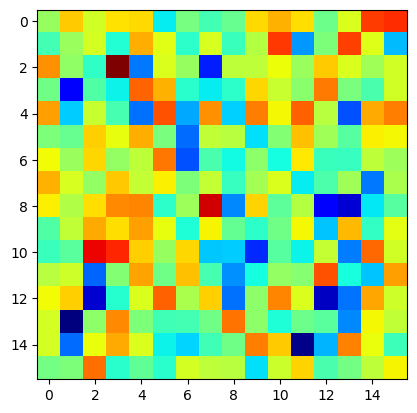

In [41]:
output = plt.imshow(im_out[0,:,:,0], cmap = 'jet')

In [43]:
l2_distance = np.linalg.norm(x1[0,:,:,0].flatten() - im_out[0,:,:,0].flatten())
print("L2 Distance (Euclidean):", l2_distance)

L2 Distance (Euclidean): 30.291212


In [45]:
mse = np.mean((x1[0,:,:,0] - im_out[0,:,:,0]) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 3.5842092


In [47]:
l1_distance = np.sum(np.abs(x1[0,:,:,0] - im_out[0,:,:,0]))
print("L1 Distance (Manhattan):", l1_distance)

L1 Distance (Manhattan): 240.70663
